In [123]:
import os
import sys
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

# import custom libraries
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from libs import data_utils

In [124]:
# Read last processed movie cleaned data
df = data_utils.read_last_processed_data('movies_cleaned_data')

Reading c:\Users\MULTIVISION\projects\movie-recommendation-system/data/processed/movies_cleaned_data_2024-07-11.csv...


In [125]:
# Drop unnamed column
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns='Unnamed: 0')

In [126]:
df.head()

,id,title,overview,genres,popularity,vote_average,release_year,keywords,title_wrangled
0,862,Toy Story,"['led', 'toy', 'live', 'happili', 'room', 'bir...","['anim', 'comedi', 'famili']",21.946943,7.7,1995.0,"['jealousi', 'toy', 'boy', 'friendship', 'frie...","['toy', 'stori']"
1,8844,Jumanji,"['sibl', 'discov', 'enchant', 'board', 'game',...","['adventur', 'fantasi', 'famili']",17.015539,6.9,1995.0,"['board gam', 'disappear', 'based on children ...",['jumanji']
2,15602,Grumpier Old Men,"['famili', 'wed', 'reignit', 'ancient', 'feud'...","['romanc', 'comedi']",11.712900,6.5,1995.0,"['fish', 'best friend', 'duringcreditssting', ...","['grumpier', 'old', 'men']"
3,31357,Waiting to Exhale,"['cheat', 'mistreat', 'step', 'women', 'hold',...","['comedi', 'drama', 'romanc']",3.859495,6.1,1995.0,"['based on novel', 'interracial relationship',...","['wait', 'exhal']"
4,11862,Father of the Bride Part II,"['bank', 'recov', 'daughter', 'wed', 'receiv',...",['comedi'],8.387519,5.7,1995.0,"['babi', 'midlife crisi', 'confid', 'age', 'da...","['father', 'part', 'ii']"


## Text Representation

In [127]:
text_cols = ['overview','genres','keywords','title_wrangled']

# Concatenate selected columns into a new 'text_data' column
df['text_data'] = df[text_cols].apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)

# Remove square brackets '[' and ']'
df['text_data'] = df['text_data'].str.replace('[\\[\\]]', '', regex=True)

# Drop empty rows
df = df.dropna(subset=['text_data'])
df['text_data'].isnull().sum()

0

### TF-IDF Vectorization
 - Create a sparse matrix that reflects the importance of a word in a document
 - Limits the vocabulary size to the top max_features most frequent terms based on term frequencies across the corpus.

In [128]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_data'])

## Normalize Numeric Data

In [129]:
num_cols = ['popularity', 'release_year', 'vote_average']

# Impute none values with mean
for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())

df[num_cols].isnull().sum()

popularity      0
release_year    0
vote_average    0
dtype: int64

In [130]:
df[num_cols].describe()

,popularity,release_year,vote_average
count,45493.000000,45493.000000,45493.000000
mean,2.944049,1991.907693,5.632365
std,6.009209,24.135925,1.904843
min,0.000000,1874.000000,0.000000
25%,0.400813,1978.000000,5.000000
50%,1.146347,2001.000000,6.000000
75%,3.732023,2011.000000,6.800000
max,547.488298,2020.000000,10.000000


In [131]:
df['processed_popularity'] = df['popularity'].apply(lambda x: np.log(x+1))
df['processed_vote_average'] = df['vote_average'].apply(lambda x: np.log(x+1))
df['processed_release_year'] = df['release_year']

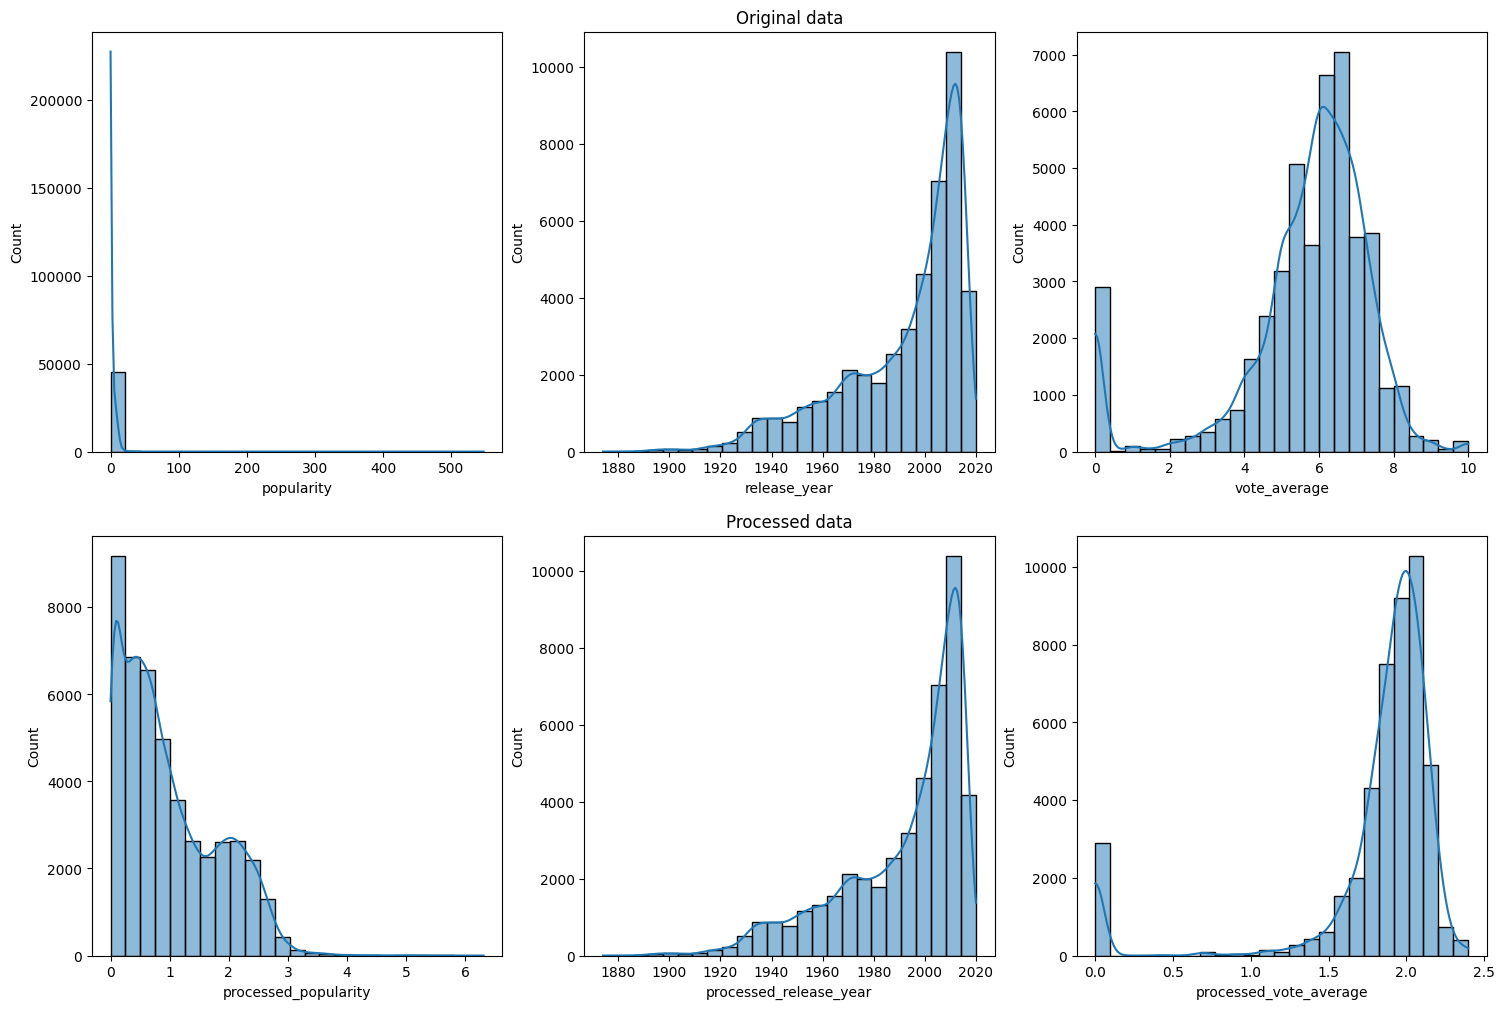

In [132]:
fig, axs = plt.subplots(2, 3, figsize=(18,12))

for col in num_cols: 
    # Display original data
    axs[0, 1].set_title(f'Original data')
    sns.histplot(df[col], bins=25, alpha=0.5, kde=True, ax=axs[0, num_cols.index(col)])

    # Display processed data
    axs[1, 1].set_title(f'Processed data')
    sns.histplot(df[f'processed_{col}'], bins=25, alpha=0.5, kde=True, ax=axs[1, num_cols.index(col)])

In [133]:
# Replace original data with processed data
if any(col.startswith('processed_') for col in df.columns):
  print('Replacing cols with processed cols')
  for col in num_cols:
    df[col] = df[f'processed_{col}']
    df = df.drop(columns=f'processed_{col}')

# Normalize numeric columns
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_num_features_df = pd.DataFrame(scaler.fit_transform(df[num_cols]))

Replacing cols with processed cols


In [134]:
normalized_num_features_df.describe()

,0,1,2
count,45493.000000,45493.000000,45493.000000
mean,0.156369,0.807587,0.753427
std,0.127342,0.165315,0.212894
min,0.000000,0.000000,0.000000
25%,0.053440,0.712329,0.747222
50%,0.121095,0.869863,0.811508
75%,0.246442,0.938356,0.856636
max,1.000000,1.000000,1.000000


## Combined Features

In [139]:
combined_features = hstack((tfidf_matrix, normalized_num_features_df))

# Print shapes to verify
print("Shape of tfidf_matrix:", tfidf_matrix.shape)
print("Shape of normalized_num_features:", normalized_num_features_df.shape)
print("Shape of combined_features:", combined_features.shape)

Shape of tfidf_matrix: (45493, 10000)
Shape of normalized_num_features: (45493, 3)
Shape of combined_features: (45493, 10003)


## Applying PCA to reduce combined_features size

In [140]:
# Assuming combined_features is a sparse matrix
from scipy.sparse import csr_matrix

# Convert to CSR format for more efficient operations
combined_features_csr = combined_features.tocsr()

# Standardize the data
scaler = StandardScaler(with_mean=False)  # with_mean=False to work with sparse data
combined_features_standardized = scaler.fit_transform(combined_features_csr)

# Apply PCA
n_components = 100 
pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(combined_features_standardized.toarray())  # Converting sparse to dense

print(f"Original shape: {combined_features.shape}")
print(f"Reduced shape: {reduced_features.shape}")

Original shape: (45493, 10003)
Reduced shape: (45493, 100)


### Saving trained data

In [141]:
# Get today's date
today = datetime.today()

# Format the date as YYYY-MM-DD
formatted_date = today.strftime('%Y-%m-%d')

# Define the path to the processed data folder
processed_data_path = parent_dir + '/data/processed/'

# Save the combined features matrix
with open(f'{processed_data_path}/combined_features_pca100_{formatted_date}.pkl', 'wb') as f:
    pickle.dump(reduced_features, f)